In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, precision_recall_curve,confusion_matrix,auc,roc_auc_score,RocCurveDisplay, roc_curve,PrecisionRecallDisplay

import tensorflow as tf
from keras import regularizers
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, BatchNormalization,Dropout,Dense,Flatten,Conv1D


import warnings
warnings.filterwarnings('ignore')

## Read data

In [2]:
df = pd.read_csv('data/creditcard.csv')

In [3]:
df_origin = df.copy()

In [4]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
target = 'Class'

## EDA

In [6]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

Text(0, 0.5, '')

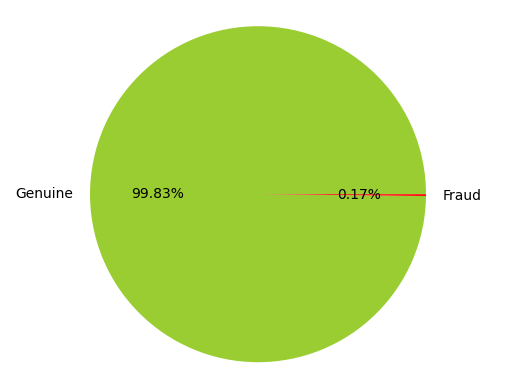

In [8]:
fig, ax = plt.subplots(1, 1)
ax.pie(df.Class.value_counts(),autopct='%1.2f%%', labels=['Genuine','Fraud'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

#### very unbalanced dataset - 0.17% of fraud

#### check correlations of 25 components:

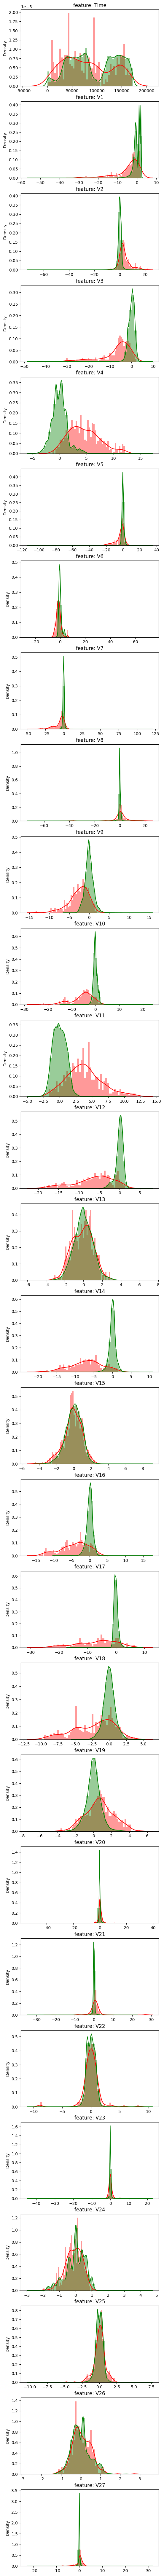

In [9]:
gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(6,28*4))
for i, col in enumerate(df[df.iloc[:,0:28].columns]):
    ax5 = plt.subplot(gs[i])
    sns.distplot(df[col][df.Class == 1], bins=50, color='r')
    sns.distplot(df[col][df.Class == 0], bins=50, color='g')
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))
plt.show()

#### drop columns where fraud class almost have no differences from non-fraud

In [10]:
df = df.drop(['V14','V16','V21','V23','V24','V26'],axis=1)

In [11]:
df = df.drop(['Time'],axis=1)

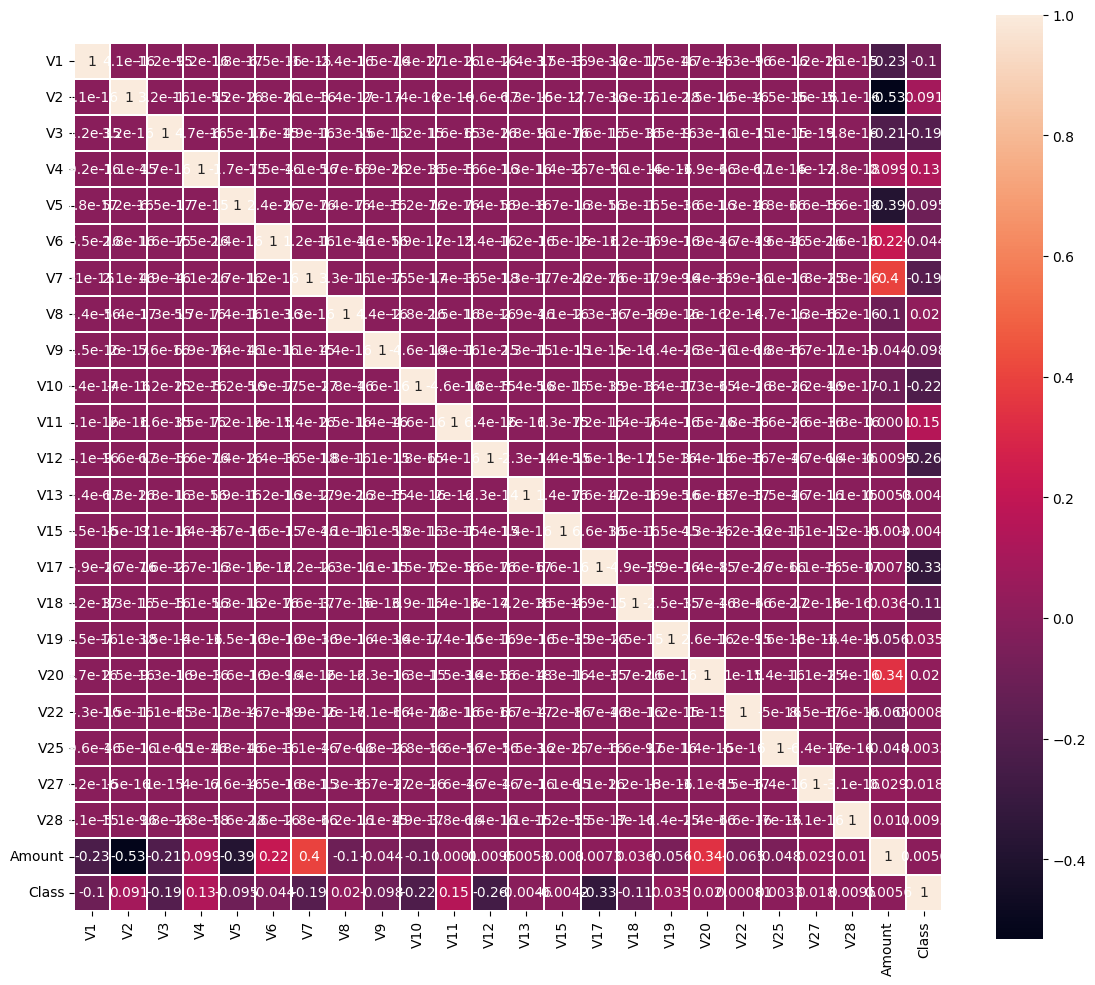

In [12]:
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True,linecolor='white', annot=True)
plt.show()

In [13]:
border = int(len(df)*0.8)
train = df[:border]
test = df[border:]

## Create an underfitted balanced dataset

In [14]:
normal = train[train.Class == 0]
fraud = train[train.Class == 1]

In [15]:
normal.Amount.describe()

count    227428.000000
mean         90.761054
std         250.488060
min           0.000000
25%           6.000000
50%          23.415000
75%          79.962500
max       19656.530000
Name: Amount, dtype: float64

In [16]:
fraud.Amount.describe()

count     417.000000
mean      125.656379
std       256.880976
min         0.000000
25%         1.000000
50%        12.310000
75%       106.900000
max      2125.870000
Name: Amount, dtype: float64

In [17]:
normal_sample = normal.sample(n=len(fraud))

In [18]:
df_balanced = pd.concat([normal_sample,fraud])
df_balanced = df_balanced.reset_index(drop=True)

In [19]:
df_balanced.shape

(834, 24)

## Splitting into features and targets

In [20]:
def split(df):
    X = df.drop(columns='Class', axis=1)
    y = df['Class']
    print(X.shape, y.shape)
    return X,y

#### split data for simple dataset

In [21]:
X_train_, y_train_ = split(train)
X_test_, y_test_ = split(test)

(227845, 23) (227845,)
(56962, 23) (56962,)


#### split training data for underfitted dataset

In [22]:
X_train_under, y_train_under = split(df_balanced)

(834, 23) (834,)


#### split training data for overfitted dataset

In [23]:
sm = SMOTE()
X_over = train.drop(columns=target, axis=1)
y_over = train[target]
X_train_over, y_train_over = sm.fit_resample(X_over,y_over)
print(X_train_over.shape)

(454856, 23)


#### functions for print and plot metrics

In [24]:
def print_metrix(y_test,y_pred,y_pred_prob):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred)) 
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred))
    print("ROC AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))    

In [25]:
def plot_metrics(y_test, y_pred_prob):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
    pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

## Training

## 1. Naive Bayes Classifier

In [26]:
bayes = GaussianNB()

In [27]:
bayes.fit(X_train_,y_train_)

GaussianNB()

In [28]:
y_pred_ = bayes.predict(X_test_)
y_pred_prob_ = bayes.predict_proba(X_test_)[:,1]

In [29]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[55785  1102]
 [   19    56]]
recall score:  0.7466666666666667
precision score:  0.04835924006908463
f1 score:  0.0908353609083536
accuracy score:  0.9803202134756505
ROC AUC: 0.9541302347929521


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


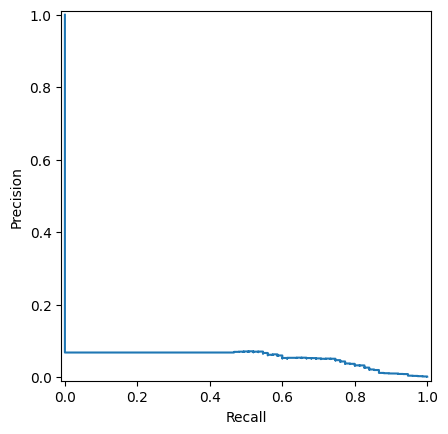

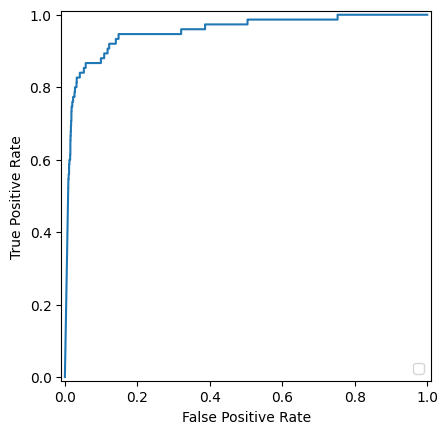

In [30]:
plot_metrics(y_test_, y_pred_prob_)

In [31]:
bayes.fit(X_train_under,y_train_under)

GaussianNB()

In [32]:
y_pred_under = bayes.predict(X_test_)
y_pred_prob_under = bayes.predict_proba(X_test_)[:,1]

In [33]:
print_metrix(y_test_,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[55702  1185]
 [   20    55]]
recall score:  0.7333333333333333
precision score:  0.04435483870967742
f1 score:  0.08365019011406843
accuracy score:  0.9788455461535761
ROC AUC: 0.9415791539953475


In [34]:
bayes.fit(X_train_over,y_train_over)

GaussianNB()

In [35]:
y_pred_over = bayes.predict(X_test_)
y_pred_prob_over = bayes.predict_proba(X_test_)[:,1]

In [36]:
print_metrix(y_test_,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[55541  1346]
 [   17    58]]
recall score:  0.7733333333333333
precision score:  0.04131054131054131
f1 score:  0.0784313725490196
accuracy score:  0.9760717671430076
ROC AUC: 0.9559274819671746


#### Naive Bayes performed bad on all three samples

## 2. Logistic Regression

In [37]:
lr = LogisticRegression()

In [38]:
lr.fit(X_train_,y_train_)

LogisticRegression()

In [39]:
y_pred = lr.predict(X_test_)
y_pred_prob = lr.predict_proba(X_test_)[:,1]

In [40]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[55785  1102]
 [   19    56]]
recall score:  0.7466666666666667
precision score:  0.04835924006908463
f1 score:  0.0908353609083536
accuracy score:  0.9803202134756505
ROC AUC: 0.9541302347929521


In [41]:
lr.fit(X_train_under, y_train_under)

LogisticRegression()

In [42]:
y_pred_under = lr.predict(X_test_)
y_pred_prob_under = lr.predict_proba(X_test_)[:,1]

In [43]:
print_metrix(y_test_,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[54149  2738]
 [    7    68]]
recall score:  0.9066666666666666
precision score:  0.024233784746970778
f1 score:  0.047205831308573414
accuracy score:  0.9518099785822127
ROC AUC: 0.9743388354691463


In [44]:
lr.fit(X_train_over, y_train_over)

LogisticRegression()

In [45]:
y_pred_over = lr.predict(X_test_)
y_pred_prob_over = lr.predict_proba(X_test_)[:,1]

In [46]:
print_metrix(y_test_,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[55732  1155]
 [    9    66]]
recall score:  0.88
precision score:  0.05405405405405406
f1 score:  0.10185185185185185
accuracy score:  0.9795653242512552
ROC AUC: 0.9754594195510398


#### Logistic regression also performed bad on all three samples

### 3. Random Forest

In [47]:
rf = RandomForestClassifier()

In [48]:
rf.fit(X_train_,y_train_)

RandomForestClassifier()

In [49]:
y_pred_ = rf.predict(X_test_)
y_pred_prob_ = rf.predict_proba(X_test_)[:,1]

In [50]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[56883     4]
 [   25    50]]
recall score:  0.6666666666666666
precision score:  0.9259259259259259
f1 score:  0.7751937984496124
accuracy score:  0.9994908886626171
ROC AUC: 0.9245470259754719


In [51]:
rf.fit(X_train_under,y_train_under)

RandomForestClassifier()

In [52]:
y_pred_under = rf.predict(X_test_)
y_pred_prob_under = rf.predict_proba(X_test_)[:,1]

In [53]:
print_metrix(y_test_,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[55994   893]
 [   12    63]]
recall score:  0.84
precision score:  0.06589958158995816
f1 score:  0.12221144519883609
accuracy score:  0.9841122151609846
ROC AUC: 0.9805195094368369


In [54]:
rf.fit(X_train_over,y_train_over)

RandomForestClassifier()

In [55]:
y_pred_over = rf.predict(X_test_)
y_pred_prob_over = rf.predict_proba(X_test_)[:,1]

In [56]:
print_metrix(y_test_,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[56876    11]
 [   17    58]]
recall score:  0.7733333333333333
precision score:  0.8405797101449275
f1 score:  0.8055555555555556
accuracy score:  0.9995084442259752
ROC AUC: 0.9522401720369622


In [57]:
rf.feature_importances_

array([0.01415048, 0.03570687, 0.07224782, 0.10846306, 0.02318583,
       0.00789372, 0.03334569, 0.01383264, 0.02516401, 0.20012594,
       0.10333384, 0.12706516, 0.00721177, 0.00544404, 0.12697882,
       0.0215779 , 0.00957086, 0.00820217, 0.00442786, 0.00638651,
       0.00950434, 0.0100378 , 0.02614288])

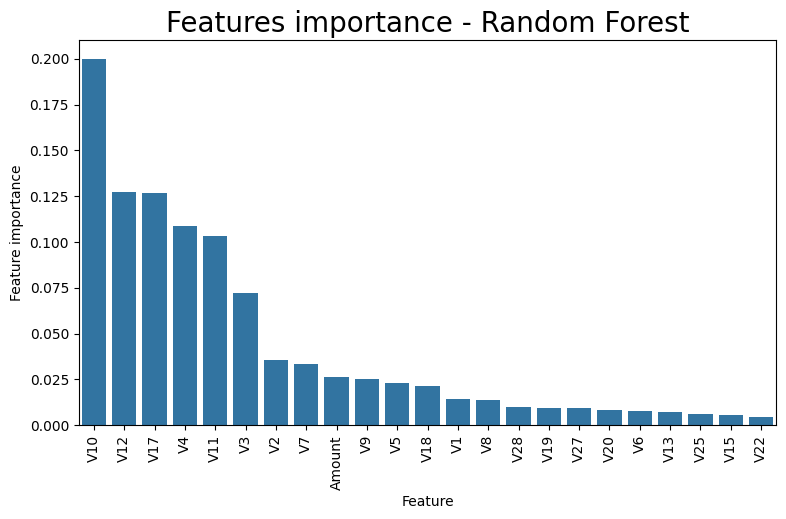

In [58]:
features = df.columns.drop(target)

plt.figure(figsize = (9,5))

feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)

g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Features importance - Random Forest',fontsize=20)
plt.show() 

#### overfitted and base sample shows the great performance

## 4. Boosting
#### 4.1 AdaBoost

In [59]:
ada = AdaBoostClassifier(random_state=2,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                         n_estimators=100)

In [60]:
ada.fit(X_train_, y_train_)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2)

In [61]:
y_pred_ = ada.predict(X_test_)
y_pred_prob_ = ada.predict_proba(X_test_)[:,1]

In [62]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[56876    11]
 [   32    43]]
recall score:  0.5733333333333334
precision score:  0.7962962962962963
f1 score:  0.6666666666666666
accuracy score:  0.9992451107756047
ROC AUC: 0.9459439473576271


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


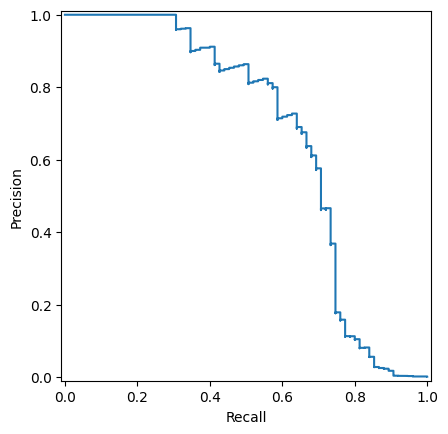

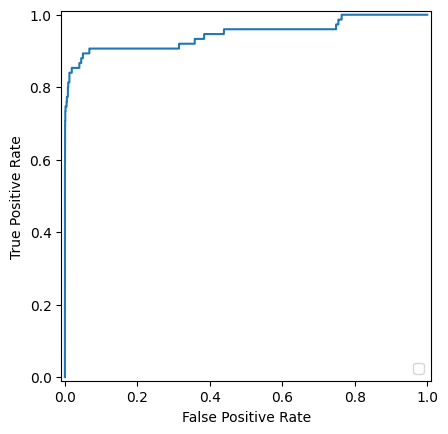

In [63]:
plot_metrics(y_test_, y_pred_prob_)

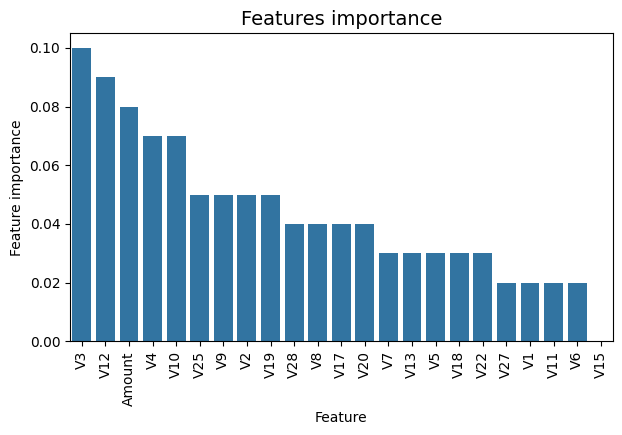

In [64]:
tmp = pd.DataFrame({'Feature': features, 'Feature importance': ada.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [65]:
ada.fit(X_train_under, y_train_under)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2)

In [66]:
y_pred_under = ada.predict(X_test_)
y_pred_prob_under = ada.predict_proba(X_test_)[:,1]

In [67]:
print_metrix(y_test_,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[54501  2386]
 [    9    66]]
recall score:  0.88
precision score:  0.026916802610114192
f1 score:  0.05223585278986941
accuracy score:  0.9579544257575225
ROC AUC: 0.9657716760126801


In [68]:
ada.fit(X_train_over, y_train_over)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2)

In [69]:
y_pred_over = ada.predict(X_test_)
y_pred_prob_over = ada.predict_proba(X_test_)[:,1]

In [70]:
print_metrix(y_test_,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[56396   491]
 [   15    60]]
recall score:  0.8
precision score:  0.1088929219600726
f1 score:  0.19169329073482427
accuracy score:  0.9911168849408377
ROC AUC: 0.9652384551830822


#### sample without balancing shows good results but random forest is still better

#### 4.2 CatBoost

In [71]:
ctb = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = 2,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=100)

In [72]:
ctb.fit(X_train_, y_train_)

0:	total: 765ms	remaining: 6m 21s
50:	total: 26.4s	remaining: 3m 52s
100:	total: 47.3s	remaining: 3m 6s
150:	total: 1m 7s	remaining: 2m 36s
200:	total: 1m 25s	remaining: 2m 7s
250:	total: 1m 46s	remaining: 1m 45s
300:	total: 2m 6s	remaining: 1m 23s
350:	total: 2m 26s	remaining: 1m 2s
400:	total: 2m 46s	remaining: 41s
450:	total: 3m 2s	remaining: 19.9s
499:	total: 3m 22s	remaining: 0us


In [73]:
y_pred_ = ctb.predict(X_test_)
y_pred_prob_ = ctb.predict_proba(X_test_)[:,1]

In [74]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[56884     3]
 [   24    51]]
recall score:  0.68
precision score:  0.9444444444444444
f1 score:  0.7906976744186046
accuracy score:  0.9995259997893332
ROC AUC: 0.9800207428762282


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


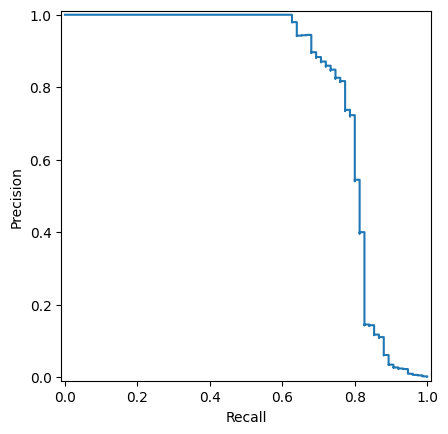

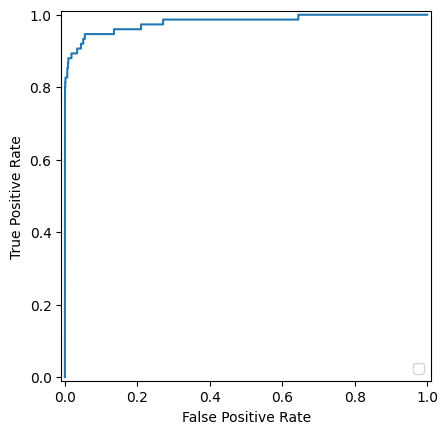

In [75]:
plot_metrics(y_test_, y_pred_prob_)

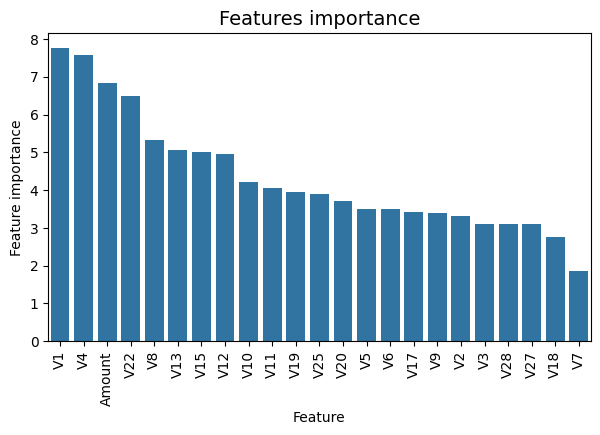

In [76]:
tmp = pd.DataFrame({'Feature': features, 'Feature importance': ctb.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

In [77]:
ctb.fit(X_train_under, y_train_under)

0:	total: 204ms	remaining: 1m 41s
50:	total: 11.3s	remaining: 1m 39s
100:	total: 22.5s	remaining: 1m 28s
150:	total: 33.7s	remaining: 1m 17s
200:	total: 44.6s	remaining: 1m 6s
250:	total: 55.8s	remaining: 55.3s
300:	total: 1m 7s	remaining: 44.4s
350:	total: 1m 18s	remaining: 33.3s
400:	total: 1m 29s	remaining: 22.1s
450:	total: 1m 38s	remaining: 10.7s
499:	total: 1m 48s	remaining: 0us


In [78]:
y_pred_under = ctb.predict(X_test_)
y_pred_prob_under = ctb.predict_proba(X_test_)[:,1]

In [79]:
print_metrix(y_test_,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[56384   503]
 [   12    63]]
recall score:  0.84
precision score:  0.11130742049469965
f1 score:  0.19656786271450857
accuracy score:  0.9909588848706155
ROC AUC: 0.9841915844862037


In [80]:
ctb.fit(X_train_over, y_train_over)

0:	total: 446ms	remaining: 3m 42s
50:	total: 24.5s	remaining: 3m 35s
100:	total: 49.2s	remaining: 3m 14s
150:	total: 1m 12s	remaining: 2m 47s
200:	total: 1m 33s	remaining: 2m 18s
250:	total: 1m 54s	remaining: 1m 54s
300:	total: 2m 17s	remaining: 1m 31s
350:	total: 2m 39s	remaining: 1m 7s
400:	total: 3m 1s	remaining: 44.7s
450:	total: 3m 20s	remaining: 21.8s
499:	total: 3m 42s	remaining: 0us


In [81]:
y_pred_over = ctb.predict(X_test_)
y_pred_prob_over = ctb.predict_proba(X_test_)[:,1]

In [82]:
print_metrix(y_test_,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[56868    19]
 [   16    59]]
recall score:  0.7866666666666666
precision score:  0.7564102564102564
f1 score:  0.7712418300653595
accuracy score:  0.999385555282469
ROC AUC: 0.9809472580144263


#### catboost with overfitting dataset shows very good result. one of the best

## 5. CNN

In [83]:
X_train_scale = MinMaxScaler().fit_transform(np.array(X_train_))
X_test_scale = MinMaxScaler().fit_transform(np.array(X_test_))

In [84]:
X_under_scale = MinMaxScaler().fit_transform(np.array(X_train_under))
X_over_scale = MinMaxScaler().fit_transform(np.array(X_train_over))

In [85]:
model=Sequential()
model.add(Conv1D(32,2,activation='relu',input_shape=(23,1)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,2,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [86]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 22, 32)              │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 22, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 21, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1344)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          86,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,785 (354.63 KB)

 Trainable params: 90,593 (353.88 KB)

 Non-trainable params: 192 (768.00 B)

In [87]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy','precision','recall'])

In [88]:
epochs = 10

In [89]:
history = model.fit(X_train_scale,y_train_,epochs=epochs,validation_data=(X_test_scale,y_test_))

Epoch 1/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 103s 13ms/step - accuracy: 0.9915 - loss: 0.0271 - precision: 0.2122 - recall: 0.3391 - val_accuracy: 0.9992 - val_loss: 0.0037 - val_precision: 0.6786 - val_recall: 0.7600
Epoch 2/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 90s 13ms/step - accuracy: 0.9992 - loss: 0.0051 - precision: 0.8852 - recall: 0.6552 - val_accuracy: 0.9989 - val_loss: 0.0052 - val_precision: 0.5686 - val_recall: 0.7733
Epoch 3/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 93s 13ms/step - accuracy: 0.9991 - loss: 0.0047 - precision: 0.8371 - recall: 0.6354 - val_accuracy: 0.9986 - val_loss: 0.0066 - val_precision: 0.4715 - val_recall: 0.7733
Epoch 4/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - accuracy: 0.9993 - loss: 0.0042 - precision: 0.8800 - recall: 0.7108 - val_accuracy: 0.9984 - val_loss: 0.0069 - val_precision: 0.4470 - val_recall: 0.7867
Epoch 5/10
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.9993 - loss: 0.0046 - precision: 0.8553 - recall: 0.7100 - val_accuracy: 0.

In [90]:
y_pred_prob_ = model.predict(X_test_scale)
y_pred_ = list(map(lambda x: 0 if x<0.5 else 1,y_pred_prob_))

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [91]:
print_metrix(y_test_,y_pred_,y_pred_prob_)

test-set confusion matrix:
 [[56744   143]
 [   15    60]]
recall score:  0.8
precision score:  0.2955665024630542
f1 score:  0.4316546762589928
accuracy score:  0.9972262209894316
ROC AUC: 0.9696952437873914


In [92]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy','precision','recall'])

In [93]:
history = model.fit(X_under_scale,y_train_under,epochs=epochs,validation_data=(X_test_scale,y_test_))

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.7381 - loss: 1.8513 - precision: 0.9958 - recall: 0.4901 - val_accuracy: 0.9478 - val_loss: 0.1751 - val_precision: 0.0221 - val_recall: 0.8933
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.7879 - loss: 1.4169 - precision: 0.9854 - recall: 0.5916 - val_accuracy: 0.4792 - val_loss: 0.8790 - val_precision: 0.0025 - val_recall: 0.9733
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.8269 - loss: 0.6990 - precision: 0.9981 - recall: 0.6710 - val_accuracy: 0.1105 - val_loss: 1.9829 - val_precision: 0.0015 - val_recall: 0.9867
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.8654 - loss: 0.5224 - precision: 0.9885 - recall: 0.7343 - val_accuracy: 0.0243 - val_loss: 3.1034 - val_precision: 0.0013 - val_recall: 1.0000
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.9047 - loss: 0.3341 - precision: 0.9655 - recall: 0.8423 - val_accuracy: 0.0107 - val_loss: 3.

In [94]:
y_pred_prob_under = model.predict(X_test_scale)
y_pred_under = list(map(lambda x: 0 if x<0.5 else 1,y_pred_prob_under))

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [95]:
print_metrix(y_test_,y_pred_under,y_pred_prob_under)

test-set confusion matrix:
 [[  142 56745]
 [    0    75]]
recall score:  1.0
precision score:  0.0013199577613516368
f1 score:  0.002636435539151068
accuracy score:  0.0038095572486921106
ROC AUC: 0.942800991439169


In [96]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy','precision','recall'])

In [97]:
history = model.fit(X_over_scale,y_train_over,epochs=epochs,validation_data=(X_test_scale,y_test_))

Epoch 1/10
14215/14215 ━━━━━━━━━━━━━━━━━━━━ 101s 7ms/step - accuracy: 0.9447 - loss: 0.1524 - precision: 0.9719 - recall: 0.9156 - val_accuracy: 0.9192 - val_loss: 0.3133 - val_precision: 0.0144 - val_recall: 0.8933
Epoch 2/10
14215/14215 ━━━━━━━━━━━━━━━━━━━━ 1839s 129ms/step - accuracy: 0.9542 - loss: 0.1262 - precision: 0.9785 - recall: 0.9287 - val_accuracy: 0.9404 - val_loss: 0.2387 - val_precision: 0.0197 - val_recall: 0.9067
Epoch 3/10
14215/14215 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - accuracy: 0.9574 - loss: 0.1162 - precision: 0.9795 - recall: 0.9342 - val_accuracy: 0.9498 - val_loss: 0.1944 - val_precision: 0.0230 - val_recall: 0.8933
Epoch 4/10
14215/14215 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step - accuracy: 0.9599 - loss: 0.1101 - precision: 0.9809 - recall: 0.9379 - val_accuracy: 0.9540 - val_loss: 0.1704 - val_precision: 0.0250 - val_recall: 0.8933
Epoch 5/10
14215/14215 ━━━━━━━━━━━━━━━━━━━━ 96s 7ms/step - accuracy: 0.9619 - loss: 0.1042 - precision: 0.9818 - recall: 0.9415 - val_a

In [98]:
y_pred_prob_over = model.predict(X_test_scale)
y_pred_over = list(map(lambda x: 0 if x<0.5 else 1,y_pred_prob_over))

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [99]:
print_metrix(y_test_,y_pred_over,y_pred_prob_over)

test-set confusion matrix:
 [[56010   877]
 [   10    65]]
recall score:  0.8666666666666667
precision score:  0.06900212314225053
f1 score:  0.127826941986234
accuracy score:  0.984428215301429
ROC AUC: 0.97183304914421


In [100]:
def history_plot(metric):
    epochRange = range(1,epochs+1)
    plt.plot(epochRange,history.history[metric])
    plt.plot(epochRange,history.history[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{metric}')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

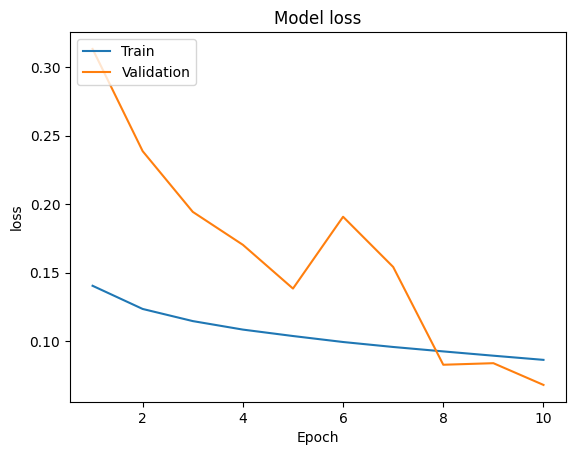

In [101]:
history_plot('loss')

#### Random forest is still better compared to convolutional neural network
#### Dataset without balancing and overfitted dataset shows same recall as random forest, but precision is much worse. Underfitted dataset shows precision and accuracy almost equal to 0.

## 6. Autoencoder

#### we will use autoencoder to find anomalies. we will train model only on non-fraud data and then predict on real test dataset using this model. fraud transactions should have higher error after running through model then non-fraud
#### first we will create train dataset consist of only non-fraud elements

In [102]:
df_enc = pd.DataFrame(MinMaxScaler().fit_transform(df_origin), columns=df_origin.columns)

In [103]:
border = int(len(df_origin)*0.8)

In [104]:
train = df_enc[:border]
test = df_enc[border:]

In [105]:
test[target].value_counts()

Class
0.0    56887
1.0       75
Name: count, dtype: int64

In [106]:
train = train[train[target]==0]

In [107]:
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]

#### split train datainto train and validation

In [108]:
val_border = int(len(X_train)*0.9)
X_train, X_val = X_train[:val_border], X_train[val_border:]

In [109]:
X_train.shape, X_val.shape, X_test.shape

((204685, 30), (22743, 30), (56962, 30))

#### build a model

In [110]:
input_dim = X_train.shape[1]

learning_rate = 1e-5

input_layer = Input(shape=(input_dim, ))
encoder = Dense(128, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(64, activation="relu")(encoder)
encoder = Dense(16, activation="relu")(encoder)
encoder = Dense(4, activation="relu")(encoder)

decoder = Dense(16 , activation='relu')(encoder)
decoder = Dense(64, activation='relu')(decoder)
decoder = Dense(128, activation='tanh')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [111]:
autoencoder.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,690 (104.26 KB)

 Trainable params: 26,690 (104.26 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
autoencoder.compile(metrics=['accuracy','precision','recall'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [113]:
history = autoencoder.fit(X_train, X_train,
                    epochs=50,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    )

Epoch 1/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8715 - loss: 0.0898 - precision: 0.9944 - recall: 0.3682 - val_accuracy: 0.9888 - val_loss: 0.0516 - val_precision: 1.0000 - val_recall: 0.4679
Epoch 2/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9917 - loss: 0.0521 - precision: 1.0000 - recall: 0.4395 - val_accuracy: 0.9888 - val_loss: 0.0511 - val_precision: 1.0000 - val_recall: 0.4725
Epoch 3/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9918 - loss: 0.0516 - precision: 1.0000 - recall: 0.4509 - val_accuracy: 0.9888 - val_loss: 0.0509 - val_precision: 1.0000 - val_recall: 0.4766
Epoch 4/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9919 - loss: 0.0514 - precision: 1.0000 - recall: 0.4518 - val_accuracy: 0.9888 - val_loss: 0.0508 - val_precision: 1.0000 - val_recall: 0.4775
Epoch 5/50
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9921 - loss: 0.0513 - precision: 1.0000 - recall: 0.4522 - val_accuracy: 0.9888 - v

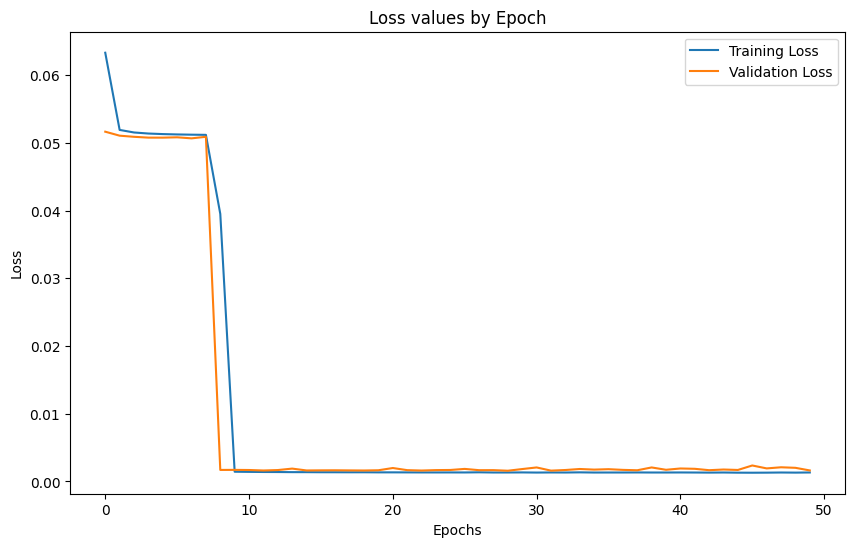

In [114]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

#### run X_test through autoencoder

In [115]:
reconstructions = autoencoder.predict(X_test, verbose=0)

#### calculate mean absolute error between real X_test and reconstructed X_test

In [116]:
error = np.array(mae(reconstructions, X_test))

In [117]:
error

array([0.01235905, 0.01953803, 0.02063713, ..., 0.02635162, 0.02789687,
       0.02481639])

#### find suitable threshold, maximising recall and precision. but recall is more important metrics for us

In [118]:
def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
    print("cm = {}".format(confusion_matrix(labels, predictions)))

In [119]:
def predict(error, threshold):
  return (np.array(error) > threshold)*1 

In [120]:
times = 50
thrsh = 0
for i in range(times):
    gap = max(error)/times
    thrsh += gap
    print(thrsh)
    preds = predict(error, thrsh)
    print_stats(preds, y_test)
    print('-------')

0.007780670817110031
Accuracy = 0.001316667251852112
Precision = 0.001316667251852112
Recall = 1.0
cm = [[    0 56887]
 [    0    75]]
-------
0.015561341634220061
Accuracy = 0.01383378392612619
Precision = 0.0013333570374584438
Recall = 1.0
cm = [[  713 56174]
 [    0    75]]
-------
0.023342012451330094
Accuracy = 0.37000105333380146
Precision = 0.002002503128911139
Recall = 0.96
cm = [[21004 35883]
 [    3    72]]
-------
0.031122683268440123
Accuracy = 0.8463712650538956
Precision = 0.007604994324631101
Recall = 0.8933333333333333
cm = [[48144  8743]
 [    8    67]]
-------
0.03890335408555015
Accuracy = 0.9675046522242898
Precision = 0.0321390937829294
Recall = 0.8133333333333334
cm = [[55050  1837]
 [   14    61]]
-------
0.04668402490266018
Accuracy = 0.9893437730416769
Precision = 0.08695652173913043
Recall = 0.7466666666666667
cm = [[56299   588]
 [   19    56]]
-------
0.05446469571977021
Accuracy = 0.9942768863452828
Precision = 0.13196480938416422
Recall = 0.6
cm = [[56591 

#### the best metrics combination:

In [121]:
threshold = 0.046428937091166814
preds = predict(error, threshold)
print_stats(preds, y_test)

Accuracy = 0.9889926617745164
Precision = 0.08433734939759036
Recall = 0.7466666666666667
cm = [[56279   608]
 [   19    56]]


#### precision is very low

## Cunclusion

#### Overfitted catboost (recall=0.79 and precision=0.76) and overfitted random forest (recall=0.77 and precision=0.84) -- are the best models